In [1]:
using OffsetArrays

In [2]:
function BP_th(H, tus)
    p1 = prod(1 .+ tus)*exp(H)
    p2 = prod(1 .- tus)*exp(-H)
    if p1+p2==0
        println("conflicting messages in BP_th")
    end
    th = (p1-p2)/(p1+p2)
end

function BP_tu(s, ths)
    tu = s*prod(ths)
end

BP_tu (generic function with 1 method)

In [3]:
function dist_sigmas(s, ths_0, σs, ν)
    k = length(ths_0)
    ind = 0
    for sig in Iterators.product(fill(-1:2:1,k)...)
        ind += 1
        σs[ind] = sig
        if prod(sig) == s
            ν[ind] += prod(1 .+ sig.*ths_0)
        end
    end
    ν ./= sum(ν)
    ν, σs
end

dist_sigmas (generic function with 1 method)

In [4]:
using StatsBase, ProgressMeter, Random
residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

residual (generic function with 1 method)

In [5]:
function RS(Λ, K, H; 
        maxiter=100, 
        popsize=1000, 
        tol=1/(√popsize),
        popP_RS = fill(0.0, 1:popsize),
        popQ_RS = fill(0.0, 1:popsize),
        q0 = fill(NaN, 1:maxiter)
    )

    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)

    
    @showprogress for t = 1:maxiter
        
        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP_RS[ind_ths]            
            s = rand((-1,1))
            popQ_RS[i] = BP_tu(s, ths)
        end
        
        q0[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ_RS[ind_tus]
            popP_RS[i] = BP_th(H, tus)
            
            q0[t]+=popP_RS[i]^2
        end
        
        q0[t] = q0[t]/length(popP_RS)
    end
    popP_RS, popQ_RS, q0
#    popP_RS, popQ_RS
end

RS (generic function with 1 method)

In [6]:
function init_pop(pop_RS, ϵ)
    pop = fill(NaN, -1:1, 1:popsize)
    pop[0,:]=popP_RS
    pop[1,:].=ϵ
    pop[-1,:].=-ϵ
    pop
end
function init_pop_alternative(pop_RS, ϵ)
    pop = fill(NaN, -1:1, 1:popsize)
    pop[0,:]=popP_RS
    for i=1:popsize
        pop[1,i]=(rand()<ϵ ? pop[0,i] : 1.0)
        pop[-1,i]=(rand()<ϵ ? pop[0,i] : -1.0)
    end
    pop
end

init_pop_alternative (generic function with 1 method)

In [7]:
function checkRS(popP)
    q0=0.0; q1=0.0
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        q0 += th[0]^2
        q1 += 0.5*th[1]*(1.0+th[0]) - 0.5*th[-1]*(1.0 - th[0])
    end
    q1= q1/size(popP, 2); q0=q0/size(popP, 2)
    q0, q1-q0
end

checkRS (generic function with 1 method)

In [323]:
function checkHardFields(popP)
    pHF = 0.0;
    for ind=1:size(popP, 2)
        th = popP[:,ind]
        pHF += 0.5*(1.0+th[0])*atanh(th[1])^2 + 0.5*(1.0 - th[0])*atanh(th[-1])^2
    end
    pHF=pHF/size(popP, 2)
end

checkHardFields (generic function with 1 method)

In [317]:
function RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS; 
        maxiter=100, 
        popsize=1000, 
        tol=1/(√popsize),
        popP = init_pop(popP_RS, 0.9),
        popQ = init_pop(popQ_RS, 0.9),
        q0=fill(NaN, 1:maxiter),
        V=fill(NaN, 1:maxiter)
    )
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    wΛ1 = weights(Λ1)
    wK1 = weights(K1)
    
    @showprogress for t = 1:maxiter

        for i = 1:popsize
            k = sample(eachindex(K1), wK1)
            ind_ths = rand(1:popsize, k)
            ths = popP[:,ind_ths]            
            s = rand((-1,1))
            popQ[0,i] = BP_tu(s, ths[0,:])
            
            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            #@show σ, elts, prod(σ)*s
            popQ[1,i] = BP_tu(s, elts)

            ν = fill(0.0, 1:2^k)
            σs = fill(tuple(fill(NaN, k)...), 1:2^k)
            ν, σs = dist_sigmas(-s, ths[0,:], σs, ν)
            wν = weights(ν)
            ind = sample(eachindex(ν), wν)
            σ = convert.(Int64, σs[ind])
            elts = [ths[s,i] for (i,s) ∈ zip(eachindex(σ), σ)]
            #@show σ, elts, prod(σ)*s
            popQ[-1,i] = BP_tu(s, elts)
        end

        q0[t]=0.0; V[t]=0.0
        
        for i = 1:popsize
            d = sample(eachindex(Λ1), wΛ1)
            ind_tus = rand(1:popsize, d)
            tus = popQ[:,ind_tus]
            #@show tus
            popP[0,i] = BP_th(H, tus[0,:])
            popP[-1,i] = BP_th(H, tus[-1,:])
            popP[1,i] = BP_th(H, tus[1,:])
            
            q0[t]+= popP[0,i]^2
            V[t]+= 0.5*popP[1,i]*(1.0+popP[0,i]) - 0.5*popP[-1,i]*(1.0 - popP[0,i])
        end
        
        q0[t] = q0[t]/size(popP, 2)
        V[t] = V[t]/size(popP, 2)
    end    
    V = V .- q0
    #popP, popQ
    popP, popQ, q0, V 
end

RSB_entropic_m1 (generic function with 1 method)

In [324]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
H = 1.7
popsize = 10^4
maxiter = 10^2
popP_RS = fill(NaN, 1:popsize)
popQ_RS = fill(NaN, 1:popsize)
q0 = fill(NaN, 1:maxiter)
popP_RS, popQ_RS, q0= RS(Λ, K, H, maxiter=10^2, popsize=popsize);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


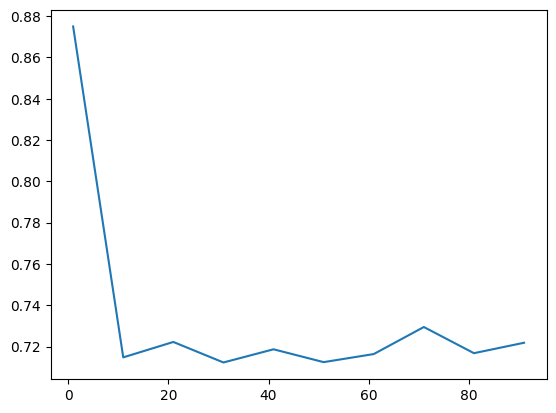

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3fc9b4d8d0>

In [325]:
using PyPlot
plot(1:10:maxiter, q0[1:10:maxiter])

In [326]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
popP = fill(NaN, -1:1, 1:popsize);
popQ = fill(NaN, -1:1, 1:popsize);
popP, popQ, q0, V = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


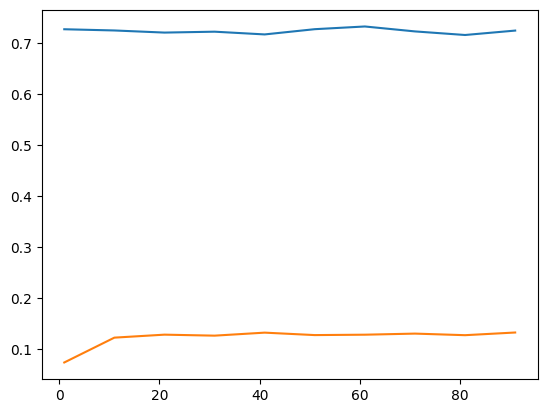

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3fc9bf65f8>

In [319]:
using PyPlot
plot(1:10:maxiter, q0[1:10:maxiter])
plot(1:10:maxiter, V[1:10:maxiter])

In [327]:
checkRS(popP), checkHardFields(popP)

((0.7274609419409076, 0.03224365386055461), 6.649653358445573)

In [328]:
q0=fill(NaN, 1:maxiter)
V=fill(NaN, 1:maxiter)
popP = init_pop_alternative(popP_RS, 0.1);
popQ = init_pop_alternative(popQ_RS, 0.1);
popP, popQ, q0, V = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


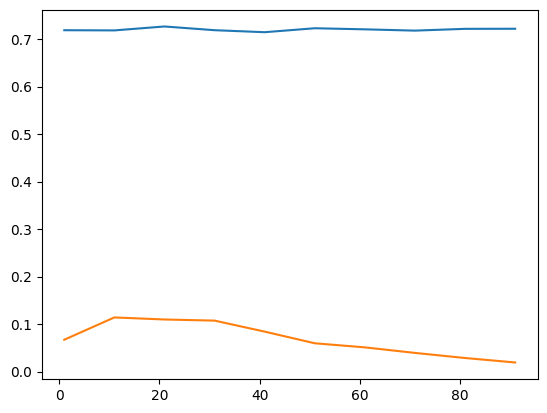

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3fc9ab7198>

In [329]:
using PyPlot
plot(1:10:maxiter, q0[1:10:maxiter])
plot(1:10:maxiter, V[1:10:maxiter])

In [330]:
checkRS(popP), checkHardFields(popP)

((0.7183428954400368, 0.01767155941504528), 5.885872310889972)

Some tests
---

In [15]:
using Unzip

Try at $f_3=0.2$ (where $H_{sp}=1.872(1)$)
---

* with population of size $10^4$

In [124]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3

Hs = vcat(0.0:0.5:1.5, 1.6:0.1:1.8, 1.71:0.01:1.79)
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, Vs[maxiter, i]
end
H_f0p2_pop1e4 = Hs
q0_1_f0p2_pop1e4 = q0s_1
q0_f0p2_pop1e4 = q0s
V_f0p2_pop1e4 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


(H, Vs[maxiter, i]) = (0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:58


(H, Vs[maxiter, i]) = (0.5, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, Vs[maxiter, i]) = (1.0, -1.1102230246251565e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


(H, Vs[maxiter, i]) = (1.5, -3.3306690738754696e-16)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:03


(H, Vs[maxiter, i]) = (1.6, 2.0048407378681077e-12)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


(H, Vs[maxiter, i]) = (1.7, 0.27340626133886803)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


(H, Vs[maxiter, i]) = (1.8, 0.2610646467343809)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, Vs[maxiter, i]) = (1.71, -4.042414913918435e-8)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


(H, Vs[maxiter, i]) = (1.72, -2.1184561571629956e-7)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


(H, Vs[maxiter, i]) = (1.73, 0.273201407435278)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


(H, Vs[maxiter, i]) = (1.74, -1.0126875433780214e-6)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:52


(H, Vs[maxiter, i]) = (1.75, 0.26645818270556365)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


(H, Vs[maxiter, i]) = (1.76, 0.26925076244217505)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


(H, Vs[maxiter, i]) = (1.77, 0.2701831163633718)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


(H, Vs[maxiter, i]) = (1.78, 0.2601833386143252)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:58


(H, Vs[maxiter, i]) = (1.79, 0.2613664794411028)


Plot the evolution along iterations

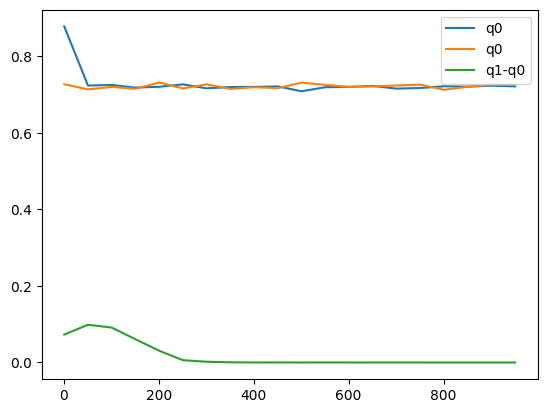

PyObject <matplotlib.legend.Legend object at 0x7f3fe8693400>

In [155]:
using PyPlot
i=8
plot(1:50:maxiter, q0_1_f0p2_pop1e4[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p2_pop1e4[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p2_pop1e4[1:50:maxiter, i], label="q1-q0")
legend()

Average after convergence

In [150]:
using Statistics
cut = 600
means_V_f0p2_pop1e4 = mean.(V_f0p2_pop1e4[cut:maxiter, i] for i=1:size(V_f0p2_pop1e4, 2))
stds_V_f0p2_pop1e4 = std.(V_f0p2_pop1e4[cut:maxiter, i] for i=1:size(V_f0p2_pop1e4, 2))
H_f0p2_pop1e4[5:7], means_V_f0p2_pop1e4[5:7], stds_V_f0p2_pop1e4[5:7]

([1.6, 1.7, 1.8], [1.35911557430978e-10, 0.2795163736616696, 0.26442396707979016], [4.209715627732373e-9, 0.004946185328821734, 0.005616020596366099])

* with population of size $10^5$

In [91]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^5
maxiter = 10^3

Hs = 1.6:0.1:1.8
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, Vs[maxiter, i]
end
H_f0p2_pop1e5 = Hs
q0_1_f0p2_pop1e5 = q0s_1
q0_f0p2_pop1e5 = q0s
V_f0p2_pop1e5 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:23
Progress: 100%|█████████████████████████████████████████| Time: 0:31:22


(H, Vs[maxiter, i]) = (1.6, 3.6048941609578833e-13)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14
Progress: 100%|█████████████████████████████████████████| Time: 0:31:30


(H, Vs[maxiter, i]) = (1.7, -2.0700693936781533e-8)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23
Progress: 100%|█████████████████████████████████████████| Time: 0:30:56


(H, Vs[maxiter, i]) = (1.8, 0.26384776985443126)


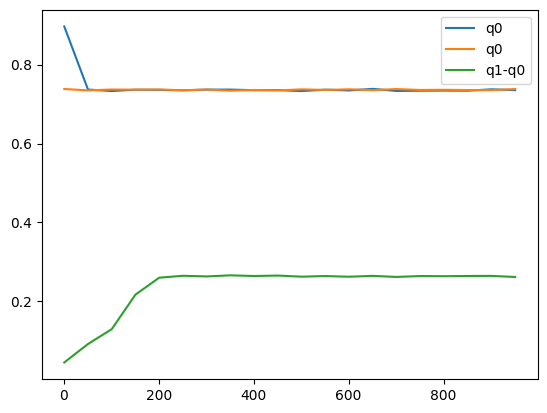

PyObject <matplotlib.legend.Legend object at 0x7f3fe91f5978>

In [95]:
using PyPlot
i=3
plot(1:50:maxiter, q0_1_f0p2_pop1e5[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p2_pop1e5[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p2_pop1e5[1:50:maxiter, i], label="q1-q0")
legend()

In [96]:
using Statistics
cut = [500, 500, 500]
means_V_f0p2_pop1e5 = mean.(V_f0p2_pop1e5[cut[i]:maxiter, i] for i=1:3)
stds_V_f0p2_pop1e5 = std.(V_f0p2_pop1e5[cut[i]:maxiter, i] for i=1:3)
means_V_f0p2_pop1e5, stds_V_f0p2_pop1e5

([-3.376588172959705e-10, 4.5342825511794317e-7, 0.26407670701996744], [9.47733943112024e-9, 1.959356192500934e-6, 0.0017165631345320103])

* Try also with the other initialization

In [125]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
ϵ = 0.1

Hs = vcat(0.0:0.5:1.5, 1.6:0.1:1.8)
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop_alternative(popP_RS, ϵ);
    popQ = init_pop_alternative(popQ_RS, ϵ);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ)
    
    @show H, Vs[maxiter, i]
end
H_f0p2_pop1e4_mixϵ0p1 = Hs
q0_1_f0p2_pop1e4_mixϵ0p1 = q0s_1
q0_f0p2_pop1e4_mixϵ0p1 = q0s
V_f0p2_pop1e4_mixϵ0p1 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


(H, Vs[maxiter, i]) = (0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:57


(H, Vs[maxiter, i]) = (0.5, 5.551115123125783e-17)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


(H, Vs[maxiter, i]) = (1.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


(H, Vs[maxiter, i]) = (1.5, 0.3099922543289475)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:07


(H, Vs[maxiter, i]) = (1.6, 0.2983146539873889)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


(H, Vs[maxiter, i]) = (1.7, 0.2797641379950172)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:52


(H, Vs[maxiter, i]) = (1.8, 0.27474202659098024)


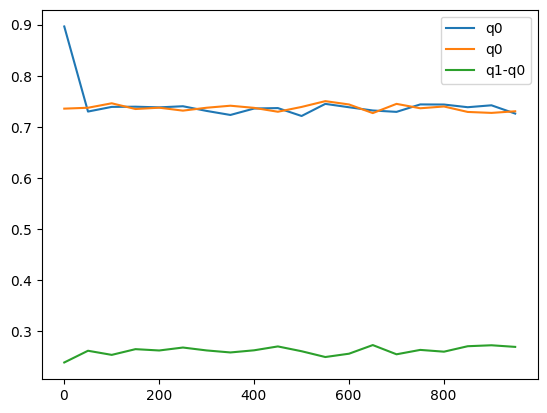

PyObject <matplotlib.legend.Legend object at 0x7f3fe19dbd68>

In [164]:
using PyPlot
i=7
plot(1:50:maxiter, q0_1_f0p2_pop1e4_mixϵ0p1[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p2_pop1e4_mixϵ0p1[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p2_pop1e4_mixϵ0p1[1:50:maxiter, i], label="q1-q0")
legend()

In [166]:
using Statistics
cut = 600
means_V_f0p2_pop1e4_mixϵ0p1 = mean.(V_f0p2_pop1e4_mixϵ0p1[cut:maxiter, i] for i=1:7)
stds_V_f0p2_pop1e4_mixϵ0p1 = std.(V_f0p2_pop1e4_mixϵ0p1[cut:maxiter, i] for i=1:7)
means_V_f0p2_pop1e4_mixϵ0p1, stds_V_f0p2_pop1e4_mixϵ0p1

([0.0, 8.998066907809872e-19, 4.1529539574507104e-18, 0.3153709477114468, 0.2962172232710817, 0.27949068588779175, 0.26448962688260885], [0.0, 2.714441917760141e-17, 8.714347362871887e-17, 0.004519979000277114, 0.005041201208373847, 0.004879920994297142, 0.005212274988019258])

with population size $10^5$

In [113]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^5
maxiter = 10^3
ϵ = 0.1

Hs = 1.6:0.1:1.8
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop_alternative(popP_RS, ϵ);
    popQ = init_pop_alternative(popQ_RS, ϵ);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ)
    
    @show H, Vs[maxiter, i]
end
H_f0p2_pop1e5_mixϵ0p1 = Hs
q0_1_f0p2_pop1e5_mixϵ0p1 = q0s_1
q0_f0p2_pop1e5_mixϵ0p1 = q0s
V_f0p2_pop1e5_mixϵ0p1 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19
Progress: 100%|█████████████████████████████████████████| Time: 0:31:04


(H, Vs[maxiter, i]) = (1.6, 0.2973901530321277)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:30:41


(H, Vs[maxiter, i]) = (1.7, 0.27907210561541174)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:17
Progress: 100%|█████████████████████████████████████████| Time: 0:30:35


(H, Vs[maxiter, i]) = (1.8, 0.26436179397374737)


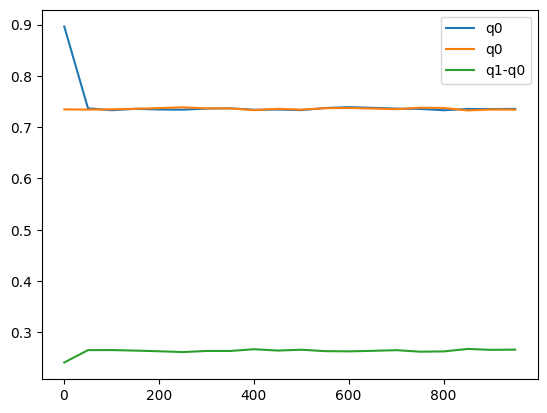

PyObject <matplotlib.legend.Legend object at 0x7f3fe888aa90>

In [116]:
using PyPlot
i=3
plot(1:50:maxiter, q0_1_f0p2_pop1e5_mixϵ0p1[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p2_pop1e5_mixϵ0p1[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p2_pop1e5_mixϵ0p1[1:50:maxiter, i], label="q1-q0")
legend()

In [117]:
using Statistics
cut = [500, 500, 500]
means_V_f0p2_pop1e5_mixϵ0p1 = mean.(V_f0p2_pop1e5_mixϵ0p1[cut[i]:maxiter, i] for i=1:length(cut))
stds_V_f0p2_pop1e5_mixϵ0p1 = std.(V_f0p2_pop1e5_mixϵ0p1[cut[i]:maxiter, i] for i=1:length(cut))
means_V_f0p2_pop1e5_mixϵ0p1, stds_V_f0p2_pop1e5_mixϵ0p1

([0.2960584639730126, 0.27909187900375404, 0.2641180621909735], [0.0016839756479481377, 0.0016854339807152318, 0.0015935946108029155])

* Plots at $f3=0.2$

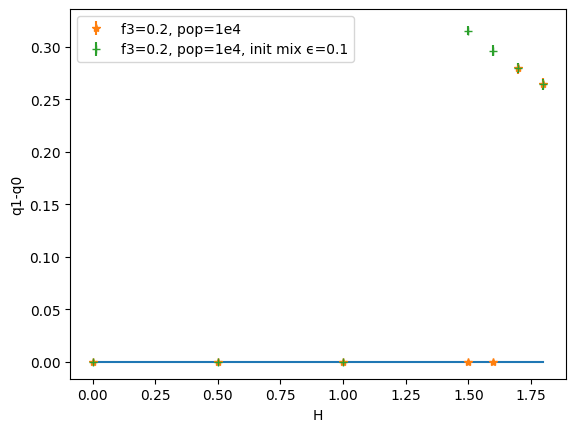

PyObject <matplotlib.legend.Legend object at 0x7f3fc90da860>

In [378]:
using PyPlot
xlabel("H")
ylabel("q1-q0")

plot((0.0,1.8), (0.0, 0.0))
errorbar(H_f0p2_pop1e4[1:7], means_V_f0p2_pop1e4[1:7], yerr = stds_V_f0p2_pop1e4[1:7], fmt="*", label="f3=0.2, pop=1e4")
#errorbar(H_f0p2_pop1e5, means_V_f0p2_pop1e5, yerr = stds_V_f0p2_pop1e5, fmt="+", label="f3=0.2, pop=1e5")
errorbar(H_f0p2_pop1e4_mixϵ0p1[1:7], means_V_f0p2_pop1e4_mixϵ0p1[1:7], yerr = stds_V_f0p2_pop1e4_mixϵ0p1[1:7], fmt="+", label="f3=0.2, pop=1e4, init mix ϵ=0.1")
#errorbar(H_f0p2_pop1e5_mixϵ0p1, means_V_f0p2_pop1e5_mixϵ0p1, yerr = stds_V_f0p2_pop1e5_mixϵ0p1, fmt="+", label="f3=0.2, pop=1e5, init mix ϵ=0.1")

legend()

* look at the presence of hard fields

In [341]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
ϵ = 0.1

Hs = 1.5:0.1:1.8
for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop_alternative(popP_RS, ϵ);
    popQ = init_pop_alternative(popQ_RS, ϵ);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ)
    
    @show H, checkRS(popP), checkHardFields(popP)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:14


(H, checkRS(popP), checkHardFields(popP)) = (1.5, (0.6814652805629621, 0.3185347194370379), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:20


(H, checkRS(popP), checkHardFields(popP)) = (1.6, (0.7024595684706887, 0.2975404315293113), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


(H, checkRS(popP), checkHardFields(popP)) = (1.7, (0.7189091647299881, 0.2810908352700119), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


(H, checkRS(popP), checkHardFields(popP)) = (1.8, (0.7306522199084647, 0.26934778009153526), Inf)


In [343]:
f3 = 0.2
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3

Hs = 1.5:0.1:1.8
for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, checkRS(popP), checkHardFields(popP)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


(H, checkRS(popP), checkHardFields(popP)) = (1.5, (0.6876701479463156, 2.220446049250313e-16), 4.111605966739566)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


(H, checkRS(popP), checkHardFields(popP)) = (1.6, (0.7017308467177146, 1.0932366123483916e-12), 4.639527016817514)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


(H, checkRS(popP), checkHardFields(popP)) = (1.7, (0.717380086213974, 4.048090640473845e-9), 5.196800890662912)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


(H, checkRS(popP), checkHardFields(popP)) = (1.8, (0.7412301022253106, 0.2587698977746894), Inf)


Try at $f_3=0.4$ (where $H_{sp}=1.126$)
---

* with population size =$10^4$

In [210]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3

Hs = vcat(0.0:0.2:1.0, 0.41:0.01:0.5)
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, Vs[maxiter, i]
end
H_f0p4_pop1e4 = Hs
q0_1_f0p4_pop1e4 = q0s_1
q0_f0p4_pop1e4 = q0s
V_f0p4_pop1e4 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, Vs[maxiter, i]) = (0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:03:01


(H, Vs[maxiter, i]) = (0.2, -6.938893903907228e-18)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


(H, Vs[maxiter, i]) = (0.4, -5.551115123125783e-17)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


(H, Vs[maxiter, i]) = (0.6, 0.6765306274801566)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


(H, Vs[maxiter, i]) = (0.8, 0.5437242325884525)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:56


(H, Vs[maxiter, i]) = (1.0, 0.44392149682731175)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


(H, Vs[maxiter, i]) = (0.41, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


(H, Vs[maxiter, i]) = (0.42, -2.7755575615628914e-17)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


(H, Vs[maxiter, i]) = (0.43, 2.7755575615628914e-17)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:57


(H, Vs[maxiter, i]) = (0.44, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:59


(H, Vs[maxiter, i]) = (0.45, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:03:05


(H, Vs[maxiter, i]) = (0.46, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:05


(H, Vs[maxiter, i]) = (0.47, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, Vs[maxiter, i]) = (0.48, 0.7725413057732129)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:03:07


(H, Vs[maxiter, i]) = (0.49, -8.326672684688674e-17)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:59


(H, Vs[maxiter, i]) = (0.5, 0.7600257165484099)


In [298]:
size(V_f0p4_pop1e4)

(1000, 16)

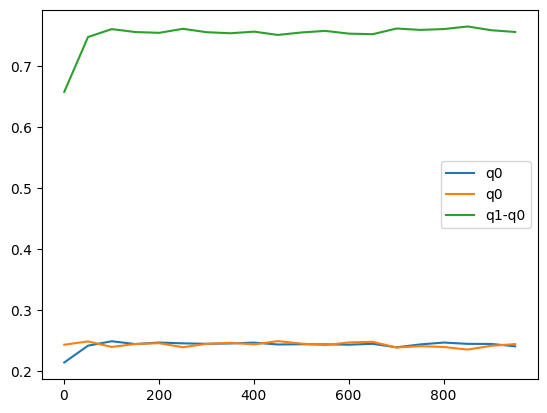

PyObject <matplotlib.legend.Legend object at 0x7f3fcb0476a0>

In [227]:
using PyPlot
i=16
plot(1:50:maxiter, q0_1_f0p4_pop1e4[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p4_pop1e4[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p4_pop1e4[1:50:maxiter, i], label="q1-q0")
legend()

In [230]:
using Statistics
cut = 600
means_V_f0p4_pop1e4 = mean.(V_f0p4_pop1e4[cut:maxiter, i] for i=1:16)
stds_V_f0p4_pop1e4 = std.(V_f0p4_pop1e4[cut:maxiter, i] for i=1:16)
means_V_f0p4_pop1e4, stds_V_f0p4_pop1e4

([0.0, -2.249516726952468e-19, -1.8688292808528195e-18, 0.6789124696588924, 0.5484994463128673, 0.45068887443033306, -1.661181582980284e-18, 1.9380451801436646e-18, 4.15295395745071e-19, 1.5227497843985937e-18, 8.30590791490142e-19, -6.229430936176065e-19, 1.4535338851077486e-18, 0.7722817377024278, 3.0454995687971873e-18, 0.7562370290242963], [0.0, 7.364538040110133e-18, 2.1100720908396724e-17, 0.0038871808373490526, 0.004918628368348953, 0.00478495342747352, 2.274279362616414e-17, 2.3553222172437885e-17, 2.4430828502501743e-17, 2.422828923302972e-17, 2.5949641129887836e-17, 2.8468007979904307e-17, 3.127587407309441e-17, 0.0028539562194235374, 3.3799524426402276e-17, 0.0028794941844260194])

* with population size $10^5$

In [82]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^5
maxiter = 10^3

Hs = 1.0:0.1:1.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, Vs[maxiter, i]
end
H_f0p4_pop1e5 = Hs
q0_1_f0p4_pop1e5 = q0s_1
q0_f0p4_pop1e5 = q0s
V_f0p4_pop1e5 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:20:40


(H, Vs[maxiter, i]) = (1.0, 0.4507385192753124)


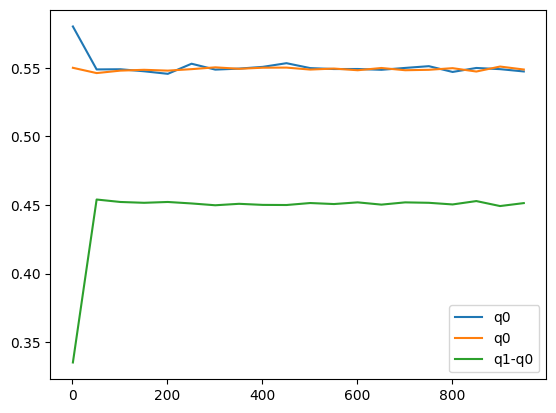

PyObject <matplotlib.legend.Legend object at 0x7f3fca0860b8>

In [290]:
using PyPlot
i=1
plot(1:50:maxiter, q0_1_f0p4_pop1e5[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p4_pop1e5[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p4_pop1e5[1:50:maxiter, i], label="q1-q0")
legend()

In [294]:
using Statistics
cut = 600
means_V_f0p4_pop1e5 = mean.(V_f0p4_pop1e5[cut:maxiter, i] for i=1:1)
stds_V_f0p4_pop1e5 = std.(V_f0p4_pop1e5[cut:maxiter, i] for i=1:1)
means_V_f0p4_pop1e5, stds_V_f0p4_pop1e5

([0.45106367550864257], [0.0015180479335842798])

In [292]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^5
maxiter = 10^3

Hs = 0.41:0.01:0.5
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, Vs[maxiter, i]
end
H_f0p4_pop1e5 = vcat(Hs, H_f0p4_pop1e5)
q0_1_f0p4_pop1e5 = vcat(q0s_1, q0_1_f0p4_pop1e5)
q0_f0p4_pop1e5 = vcat(q0s, q0_f0p4_pop1e5)
V_f0p4_pop1e5 = vcat(Vs, V_f0p4_pop1e5);

Progress:   5%|█▉                                       |  ETA: 0:00:57

LoadError: [91mInterruptException:[39m

In [272]:
H_f0p4_pop1e5_H0p41to0p5 = Hs
q0_1_f0p4_pop1e5_H0p41to0p5 = q0s_1
q0_f0p4_pop1e5_H0p41to0p5 = q0s
V_f0p4_pop1e5_H0p41to0p5 = Vs;
size(V_f0p4_pop1e5_H0p41to0p5, 2)

10

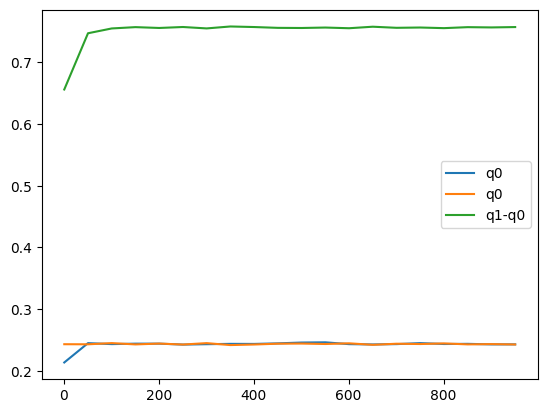

PyObject <matplotlib.legend.Legend object at 0x7f3fca4daf98>

In [271]:
using PyPlot
i=10
plot(1:50:maxiter, q0_1_f0p4_pop1e5_H0p41to0p5[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p4_pop1e5_H0p41to0p5[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p4_pop1e5_H0p41to0p5[1:50:maxiter, i], label="q1-q0")
legend()

In [273]:
using Statistics
cut = 600
means_V_f0p4_pop1e5_H0p41to0p5 = mean.(V_f0p4_pop1e5_H0p41to0p5[cut:maxiter, i] for i=1:size(V_f0p4_pop1e5_H0p41to0p5, 2))
stds_V_f0p4_pop1e5_H0p41to0p5 = std.(V_f0p4_pop1e5_H0p41to0p5[cut:maxiter, i] for i=1:size(V_f0p4_pop1e5_H0p41to0p5, 2))
means_V_f0p4_pop1e5_H0p41to0p5, stds_V_f0p4_pop1e5_H0p41to0p5

([-9.690225900718323e-19, 6.229430936176065e-19, -4.15295395745071e-19, 3.4607949645422587e-19, 1.3843179858169034e-19, -1.4535338851077486e-18, 1.0382384893626776e-18, 0.7720793394775721, 0.764133983603595, 0.7562185944047495], [2.480637478375057e-17, 2.4933638799700817e-17, 2.3051762692026084e-17, 2.7298623006160024e-17, 2.6694098002217868e-17, 3.008313416433441e-17, 2.9778735204065e-17, 0.0008676131662662186, 0.0009935144515400003, 0.0008745155332591677])

* with the other initialization

In [127]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3
ϵ = 0.1

Hs = 0.0:0.2:1.0
q0s_1=fill(NaN, 1:maxiter, eachindex(Hs))
q0s=fill(NaN, 1:maxiter, eachindex(Hs))
Vs=fill(NaN, 1:maxiter, eachindex(Hs))

for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS, q0s_1[:,i] = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop_alternative(popP_RS, ϵ);
    popQ = init_pop_alternative(popQ_RS, ϵ);
    popP, popQ, q0s[:,i], Vs[:,i] = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize, popP=popP, popQ=popQ)
    
    @show H, Vs[maxiter, i]
end
H_f0p4_pop1e4_mixϵ0p1 = Hs
q0_1_f0p4_pop1e4_mixϵ0p1 = q0s_1
q0_f0p4_pop1e4_mixϵ0p1 = q0s
V_f0p4_pop1e4_mixϵ0p1 = Vs;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


(H, Vs[maxiter, i]) = (0.0, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:01


(H, Vs[maxiter, i]) = (0.2, 6.938893903907228e-18)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47


(H, Vs[maxiter, i]) = (0.4, 0.0)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


(H, Vs[maxiter, i]) = (0.6, 0.67907009388779)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


(H, Vs[maxiter, i]) = (0.8, 0.5419937576648812)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:01


(H, Vs[maxiter, i]) = (1.0, 0.4549011965929963)


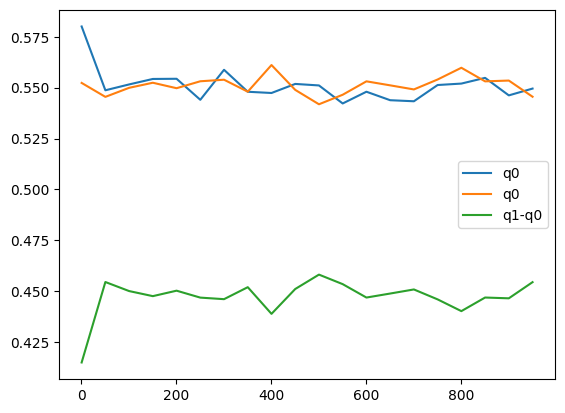

PyObject <matplotlib.legend.Legend object at 0x7f3fdcbf7470>

In [198]:
using PyPlot
i=6
plot(1:50:maxiter, q0_1_f0p4_pop1e4_mixϵ0p1[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, q0_f0p4_pop1e4_mixϵ0p1[1:50:maxiter, i], label="q0")
plot(1:50:maxiter, V_f0p4_pop1e4_mixϵ0p1[1:50:maxiter, i], label="q1-q0")
legend()

In [200]:
using Statistics
cut = 600
means_V_f0p4_pop1e4_mixϵ0p1 = mean.(V_f0p4_pop1e4_mixϵ0p1[cut:maxiter, i] for i=1:6)
stds_V_f0p4_pop1e4_mixϵ0p1 = std.(V_f0p4_pop1e4_mixϵ0p1[cut:maxiter, i] for i=1:6)
means_V_f0p4_pop1e4_mixϵ0p1, stds_V_f0p4_pop1e4_mixϵ0p1

([0.0, 2.768635971633807e-19, 1.245886187235213e-18, 0.6786220655915653, 0.5476893919908379, 0.4510388111446728], [0.0, 7.338200961937456e-18, 2.251420423523132e-17, 0.0037094378978178005, 0.004849103593101313, 0.005206801621635263])

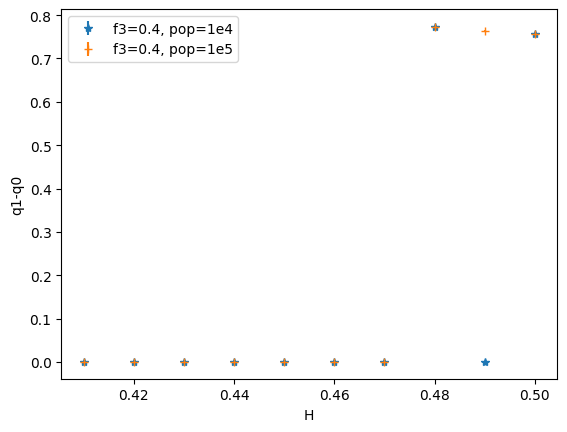

PyObject <matplotlib.legend.Legend object at 0x7f3fc9397358>

In [372]:
using PyPlot
xlabel("H")
ylabel("q1-q0")

errorbar(H_f0p4_pop1e4[7:16], means_V_f0p4_pop1e4[7:16], yerr = stds_V_f0p4_pop1e4[7:16], fmt="*", label="f3=0.4, pop=1e4")
#errorbar(H_f0p4_pop1e5, means_V_f0p4_pop1e5, yerr = stds_V_f0p4_pop1e5, fmt=".", label="f3=0.4, pop=1e5")
errorbar(H_f0p4_pop1e5_H0p41to0p5, means_V_f0p4_pop1e5_H0p41to0p5, yerr = stds_V_f0p4_pop1e5_H0p41to0p5, fmt="+", label="f3=0.4, pop=1e5")
#errorbar(H_f0p4_pop1e4_mixϵ0p1, means_V_f0p4_pop1e4_mixϵ0p1, yerr = stds_V_f0p4_pop1e4_mixϵ0p1, fmt="+", label="f3=0.4, pop=1e4, init mix ϵ=0.1")

legend()

* check the presence of hard fields

In [348]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3

Hs = 0.4:0.1:0.6
for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, checkRS(popP), checkHardFields(popP)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:19


(H, checkRS(popP), checkHardFields(popP)) = (0.4, (0.1609318223417517, -2.7755575615628914e-17), 0.19730676181019718)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:20


(H, checkRS(popP), checkHardFields(popP)) = (0.5, (0.24254434274943437, 0.7574556572505656), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:21


(H, checkRS(popP), checkHardFields(popP)) = (0.6, (0.3174937180633888, 0.6825062819366112), Inf)


In [349]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3

Hs = 0.4:0.1:0.6
for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = init_pop_alternative(popP_RS, 0.1);
    popQ = init_pop_alternative(popQ_RS, 0.1);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, checkRS(popP), checkHardFields(popP)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


(H, checkRS(popP), checkHardFields(popP)) = (0.4, (0.16622283508220007, 0.0), 0.20436058726445883)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:18


(H, checkRS(popP), checkHardFields(popP)) = (0.5, (0.2421589963746324, 0.7578410036253675), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


(H, checkRS(popP), checkHardFields(popP)) = (0.6, (0.32798052575232545, 0.6720194742476746), Inf)


In [373]:
f3 = 0.4
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
popsize = 10^4
maxiter = 10^3

Hs = 0.46:0.01:0.50
for (i,H) in pairs(Hs)
    popP_RS = fill(NaN, 1:popsize)
    popQ_RS = fill(NaN, 1:popsize)
    popP_RS, popQ_RS = RS(Λ, K, H, maxiter=maxiter, popsize=popsize)

    popP = fill(NaN, -1:1, 1:popsize);
    popQ = fill(NaN, -1:1, 1:popsize);
    popP, popQ = RSB_entropic_m1(Λ, K, H, popP_RS, popQ_RS, maxiter=maxiter, popsize=popsize)
    
    @show H, checkRS(popP), checkHardFields(popP)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:07


(H, checkRS(popP), checkHardFields(popP)) = (0.46, (0.21279364750384822, 0.7872063524961518), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:09


(H, checkRS(popP), checkHardFields(popP)) = (0.47, (0.22539321011987887, 0.7746067898801211), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


(H, checkRS(popP), checkHardFields(popP)) = (0.48, (0.2268980646355312, 0.0), 0.3146808794859855)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


(H, checkRS(popP), checkHardFields(popP)) = (0.49, (0.2344053764395053, 0.7655946235604947), Inf)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


(H, checkRS(popP), checkHardFields(popP)) = (0.5, (0.24435641734227997, 0.75564358265772), Inf)


Rigidity threshold
---

In [352]:
function HF_fraction(Λ, K;
        init_p=1.0,
        maxiter=1000)
    
    Λ1 = residual(Λ)
    K1 = residual(K)
    
    p=init_p
    for t = 1:maxiter
        q = sum(K1[k]*p^k for k in eachindex(K1))
        p = 1-sum(Λ1[d]*(1-q)^d for d in eachindex(Λ1))
    end
    p
end

HF_fraction (generic function with 1 method)

In [379]:
f3 = 0.41
Λ = OffsetVector([0,0,1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
HF_fraction(Λ, K, init_p=0.99, maxiter=5000)

0.9999999999999973